In [93]:
import os
import glob
import json
from datetime import datetime
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
from scipy.stats import binom
import pandas as pd
import pingouin as pg
import re

folder_path = "study-data"

In [94]:
rows = []

# Loop through all jsonl files
for jsonl_path in glob.glob(os.path.join(folder_path, "*.jsonl")):
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue

            try:
                record = json.loads(line)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON on line {line_num} in file {jsonl_path}")
                continue

            user_answer = record.get("user_answer", {})
            pid = record.get("PID", None)

            # Unpack user_answer entries
            for question_key, value in user_answer.items():
                if not isinstance(value, list) or len(value) != 2:
                    print(f"Unexpected format for {question_key} in file {jsonl_path}")
                    continue

                timestamp, answer = value

                rows.append({
                    "question": question_key,
                    "timestamp": timestamp,
                    "answer": answer,
                    "PID": pid,
                    "source_file": os.path.basename(jsonl_path)
                })

# Convert list of dicts to DataFrame
data = pd.DataFrame(rows)

# Optional: Convert timestamp column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')

# Display first few rows
data.head()

,question,timestamp,answer,PID,source_file
0,7first_choiceC3,2025-07-17 15:00:19.598041,Tell the patient about their condition.,3,66bfdc082ffe8d45b60263a6.jsonl
1,7second_choiceC3,2025-07-17 15:00:16.851518,Tell the patient about their condition.,3,66bfdc082ffe8d45b60263a6.jsonl
2,7third_choiceC3,2025-07-17 15:00:27.078233,Tell the patient about their condition.,3,66bfdc082ffe8d45b60263a6.jsonl
3,1first_choiceC3,2025-07-17 15:01:08.913367,"[5000, 5000, 0]",3,66bfdc082ffe8d45b60263a6.jsonl
4,1second_choiceC3,2025-07-17 15:01:28.387955,"[5000, 5000, 0]",3,66bfdc082ffe8d45b60263a6.jsonl


In [95]:
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon

participant = []
conditions = []
time = []

for src_file in data['source_file'].unique():
    for q in range(1, 13):
        for condition in range(1, 4):
            first_choice = data.loc[(data['source_file'] == src_file) & (data['question'] == f"{q}first_choiceC{condition}")]
            second_choice = data.loc[(data['source_file'] == src_file) & (data['question'] == f"{q}second_choiceC{condition}")]
            third_choice = data.loc[(data['source_file'] == src_file) & (data['question']== f"{q}third_choiceC{condition}")]

            if second_choice.shape[0] < 1 or third_choice.shape[0] < 1:
                continue
        
            t1 = first_choice.iloc[0]['timestamp']
            t2 = second_choice.iloc[0]['timestamp']
            t3 = third_choice.iloc[0]['timestamp']
            if pd.notnull(t1) and pd.notnull(t2):
                participant.append(src_file)
                conditions.append(f"C{condition}")
                # time taken between phase 3 and phase 2 CHANGE HERE TO CALCULATE TIME BETWEEN phase 1 and phase 2
                time.append((t3 - t2).total_seconds())


timing_df = pd.DataFrame({
    "participant": participant,
    "condition": conditions,
    "time_taken": time
})

# Pivot the DataFrame so each participant is a row and each condition is a column
pivot = timing_df.pivot_table(index='participant', columns='condition', values='time_taken', aggfunc='mean')

# Drop rows with missing values (participant must have all conditions)
pivot = pivot.dropna(subset=['C1', 'C2', 'C3'])


# Run the Friedman chi-square test
stat, p = friedmanchisquare(pivot['C1'], pivot['C2'], pivot['C3'])
print(f"Friedman chi-square statistic: {stat:.3f}, p-value: {p:.10f}")
# Post hoc pairwise Wilcoxon signed-rank tests
pairs = [('C1', 'C2'), ('C1', 'C3'), ('C2', 'C3')]
for cond1, cond2 in pairs:
    try:
        stat_w, p_w = wilcoxon(pivot[cond1], pivot[cond2])
        print(f"{cond1} vs {cond2}: Wilcoxon W={stat_w:.3f}, p={p_w:.4f}")
    except ValueError:
        print(f"{cond1} vs {cond2}: Not enough data for Wilcoxon test")

Friedman chi-square statistic: 20.583, p-value: 0.0000339145
C1 vs C2: Wilcoxon W=90.000, p=0.0894
C1 vs C3: Wilcoxon W=13.000, p=0.0000
C2 vs C3: Wilcoxon W=14.000, p=0.0000


[7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7]
ShapiroResult(statistic=np.float64(0.8472248507898659), pvalue=np.float64(5.803626416282163e-12))
0.8472248507898659


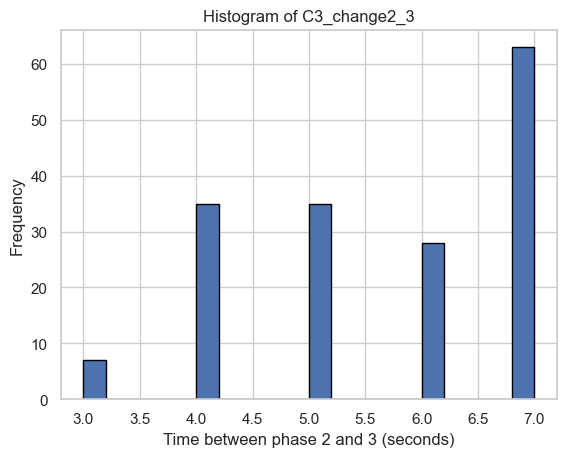

In [96]:
rows = []

C1_q1 = []
C2_q1 = []
C3_q1 = []

# Loop through all jsonl files
for jsonl_path in glob.glob(os.path.join(folder_path, "*.jsonl")):
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue

            try:
                record = json.loads(line)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON on line {line_num} in file {jsonl_path}")
                continue

            pid = record.get("PID", None)

            for condition in range (1, 4):
                condition_questions = record.get (f"C{condition}_questions")
                for q in range (7):
                    
                    if condition == 1:
                        C1_q1.append(condition_questions[1])
                    if condition == 2:
                        C2_q1.append(condition_questions[1])
                    if condition == 3:
                        C3_q1.append(condition_questions[1])

                    rows.append({
                        f"q{q}": condition_questions[q],
                        "PID": pid,
                        "condition": condition,
                            "source_file": os.path.basename(jsonl_path)
                        })

# Convert list of dicts to DataFrame
condition_question_data = pd.DataFrame(rows)

# Optional: Convert timestamp column to datetime
# data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')

# Display first few rows
condition_question_data.head()

shapiro_test = stats.shapiro(C1_q1)
print(C1_q1)
print(shapiro_test)
print(shapiro_test.statistic)

plt.hist(C1_q1, bins=20, edgecolor='black')
plt.xlabel('Time between phase 2 and 3 (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of C3_change2_3')
plt.show() 

In [97]:

aov = pg.friedman(data=condition_question_data, dv='q1', within='condition', subject='source_file')
print(aov)

             Source         W  ddof1         Q     p-unc
Friedman  condition  0.164394      2  7.890909  0.019342


In [98]:

rows = []

# Loop through all jsonl files
for jsonl_path in glob.glob(os.path.join(folder_path, "*.jsonl")):
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue

            try:
                record = json.loads(line)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON on line {line_num} in file {jsonl_path}")
                continue

            user_answer = record.get("user_answer", {})
            pid = record.get("PID", None)

            # Unpack user_answer entries
            for question_key, value in user_answer.items():
                if not isinstance(value, list) or len(value) != 2:
                    print(f"Unexpected format for {question_key} in file {jsonl_path}")
                    continue

                timestamp, answer = value

                rows.append({
                    "question": question_key,
                    "timestamp": timestamp,
                    "answer": answer,
                    "PID": pid,
                    "source_file": os.path.basename(jsonl_path)
                })

# Convert list of dicts to DataFrame
data = pd.DataFrame(rows)

# Optional: Convert timestamp column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')

# Display first few rows
data.head()
            


,question,timestamp,answer,PID,source_file
0,7first_choiceC3,2025-07-17 15:00:19.598041,Tell the patient about their condition.,3,66bfdc082ffe8d45b60263a6.jsonl
1,7second_choiceC3,2025-07-17 15:00:16.851518,Tell the patient about their condition.,3,66bfdc082ffe8d45b60263a6.jsonl
2,7third_choiceC3,2025-07-17 15:00:27.078233,Tell the patient about their condition.,3,66bfdc082ffe8d45b60263a6.jsonl
3,1first_choiceC3,2025-07-17 15:01:08.913367,"[5000, 5000, 0]",3,66bfdc082ffe8d45b60263a6.jsonl
4,1second_choiceC3,2025-07-17 15:01:28.387955,"[5000, 5000, 0]",3,66bfdc082ffe8d45b60263a6.jsonl


             Source         W  ddof1         Q     p-unc
Friedman  condition  0.002874      2  0.137931  0.933359


/var/folders/tl/m77cy_1s7_5dgtt93z3841p00000gq/T/ipykernel_37650/3888756506.py:72: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=change_data, x='condition', y='change', ci='sd', palette=["#ea801c", "purple", "#b8b8b8"])
/var/folders/tl/m77cy_1s7_5dgtt93z3841p00000gq/T/ipykernel_37650/3888756506.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=change_data, x='condition', y='change', ci='sd', palette=["#ea801c", "purple", "#b8b8b8"])


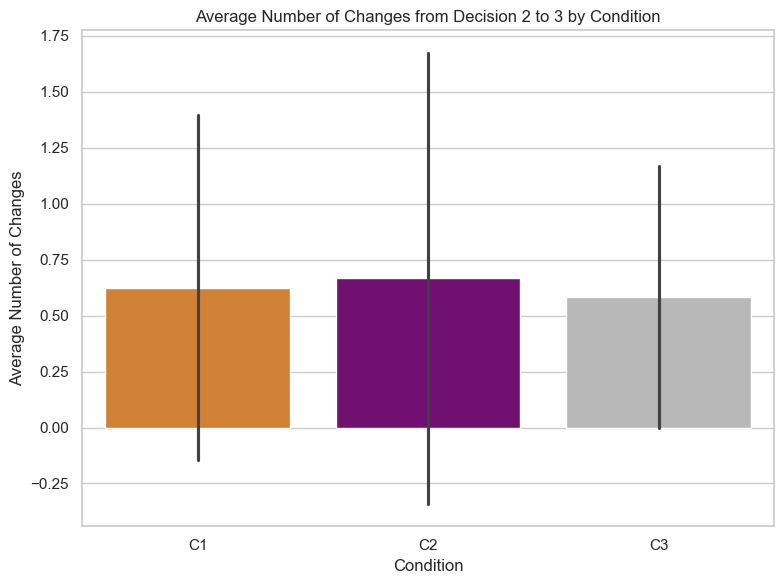

In [99]:
# SWITCH BETWEEN 2 AND 3
rows = []

participant = []
conditions = []
time = []
C1_time2_3 = []
C2_time2_3 = []
C3_time2_3 = []

C1_change2_3 = []
C2_change2_3 = []
C3_change2_3 = []


for src_file in data['source_file'].unique():
    C1_counter = 0
    C2_counter = 0
    C3_counter = 0

    for q in range(1, 13):
        for condition in range(1, 4):
            first_choice = data.loc[(data['source_file'] == src_file) & (data['question'] == f"{q}first_choiceC{condition}")]
            second_choice = data.loc[(data['source_file'] == src_file) & (data['question'] == f"{q}second_choiceC{condition}")]
            third_choice = data.loc[(data['source_file'] == src_file) & (data['question']== f"{q}third_choiceC{condition}")]

            if second_choice.shape[0] < 1 or third_choice.shape[0] < 1:
                continue
        
            t1 = first_choice.iloc[0]['timestamp']
            t2 = second_choice.iloc[0]['timestamp']
            t3 = third_choice.iloc[0]['timestamp']
            if pd.notnull(t1) and pd.notnull(t2):
                participant.append(src_file)
                conditions.append(f"C{condition}")
                # time taken between phase 3 and phase 2 CHANGE HERE TO CALCULATE TIME BETWEEN phase 1 and phase 2
                if condition == 1 and (second_choice.iloc[0]['answer']!= third_choice.iloc[0]['answer']):
                    C1_counter +=1
                if condition == 2 and (second_choice.iloc[0]['answer'] != third_choice.iloc[0]['answer']):
                    C2_counter +=1
                if condition == 3 and (second_choice.iloc[0]['answer'] != third_choice.iloc[0]['answer']):
                    C3_counter +=1

    C1_change2_3.append(C1_counter)
    C2_change2_3.append(C2_counter)
    C3_change2_3.append(C3_counter)

    rows.append({
        "change": C1_counter,
        "source_file": os.path.basename(src_file),
        "condition": "C1",
    })

    rows.append({
        "change": C2_counter,
        "source_file": os.path.basename(src_file),
        "condition": "C2",
    })

    rows.append({
        "change": C3_counter,
        "source_file": os.path.basename(src_file),
        "condition": "C3",
    })

change_data = pd.DataFrame(rows)

aov = pg.friedman(data=change_data, dv='change', within='condition', subject='source_file')
print(aov)

plt.figure(figsize=(8, 6))
sns.barplot(data=change_data, x='condition', y='change', ci='sd', palette=["#ea801c", "purple", "#b8b8b8"])
plt.title('Average Number of Changes from Decision 2 to 3 by Condition')
plt.xlabel('Condition')
plt.ylabel('Average Number of Changes')
plt.tight_layout()
plt.show()

             Source         W  ddof1         Q     p-unc
Friedman  condition  0.081439      2  3.909091  0.141629


/var/folders/tl/m77cy_1s7_5dgtt93z3841p00000gq/T/ipykernel_37650/2297951410.py:73: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=change_data, x='condition', y='change', ci='sd', palette=["#ea801c", "purple", "#b8b8b8"])
/var/folders/tl/m77cy_1s7_5dgtt93z3841p00000gq/T/ipykernel_37650/2297951410.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=change_data, x='condition', y='change', ci='sd', palette=["#ea801c", "purple", "#b8b8b8"])


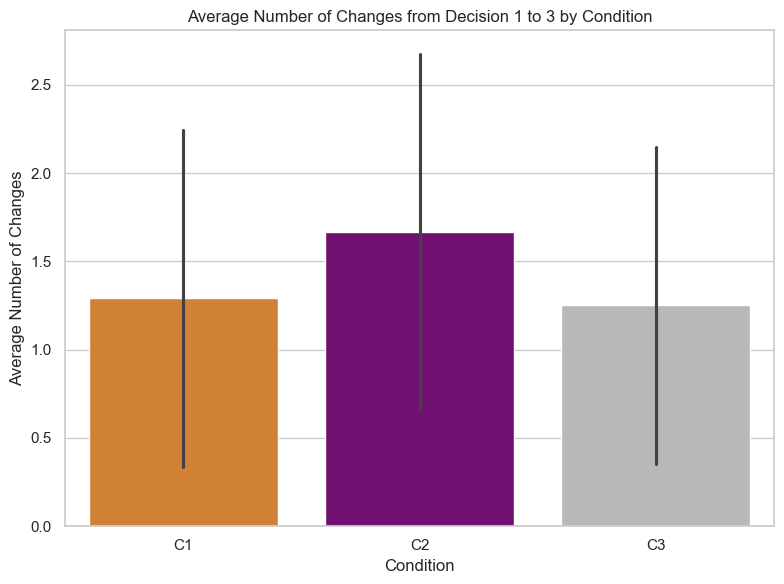

In [100]:
# SWITCH BETWEEN 1 AND 3

rows = []

participant = []
conditions = []
time = []
C1_time1_3 = []
C2_time1_3 = []
C3_time1_3 = []

C1_change1_3 = []
C2_change1_3 = []
C3_change1_3 = []


for src_file in data['source_file'].unique():
    C1_counter = 0
    C2_counter = 0
    C3_counter = 0

    for q in range(1, 13):
        for condition in range(1, 4):
            first_choice = data.loc[(data['source_file'] == src_file) & (data['question'] == f"{q}first_choiceC{condition}")]
            second_choice = data.loc[(data['source_file'] == src_file) & (data['question'] == f"{q}second_choiceC{condition}")]
            third_choice = data.loc[(data['source_file'] == src_file) & (data['question']== f"{q}third_choiceC{condition}")]

            if first_choice.shape[0] < 1 or second_choice.shape[0] < 1 or third_choice.shape[0] < 1:
                continue
        
            t1 = first_choice.iloc[0]['timestamp']
            t2 = second_choice.iloc[0]['timestamp']
            t3 = third_choice.iloc[0]['timestamp']
            if pd.notnull(t1) and pd.notnull(t2):
                participant.append(src_file)
                conditions.append(f"C{condition}")
                # time taken between phase 3 and phase 2 CHANGE HERE TO CALCULATE TIME BETWEEN phase 1 and phase 2
                if condition == 1 and (first_choice.iloc[0]['answer']!= third_choice.iloc[0]['answer']):
                    C1_counter +=1
                if condition == 2 and (first_choice.iloc[0]['answer'] != third_choice.iloc[0]['answer']):
                    C2_counter +=1
                if condition == 3 and (first_choice.iloc[0]['answer'] != third_choice.iloc[0]['answer']):
                    C3_counter +=1

    C1_change1_3.append(C1_counter)
    C2_change1_3.append(C2_counter)
    C3_change1_3.append(C3_counter)

    rows.append({
        "change": C1_counter,
        "source_file": os.path.basename(src_file),
        "condition": "C1",
    })

    rows.append({
        "change": C2_counter,
        "source_file": os.path.basename(src_file),
        "condition": "C2",
    })

    rows.append({
        "change": C3_counter,
        "source_file": os.path.basename(src_file),
        "condition": "C3",
    })

change_data = pd.DataFrame(rows)

aov = pg.friedman(data=change_data, dv='change', within='condition', subject='source_file')
print(aov)

plt.figure(figsize=(8, 6))
sns.barplot(data=change_data, x='condition', y='change', ci='sd', palette=["#ea801c", "purple", "#b8b8b8"])
plt.title('Average Number of Changes from Decision 1 to 3 by Condition')
plt.xlabel('Condition')
plt.ylabel('Average Number of Changes')
plt.tight_layout()
plt.show()

             Source         W  ddof1         Q     p-unc
Friedman  condition  0.072761      2  3.492537  0.174424


/var/folders/tl/m77cy_1s7_5dgtt93z3841p00000gq/T/ipykernel_37650/2664791384.py:73: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=change_data, x='condition', y='change', ci='sd', palette=["#ea801c", "purple", "#b8b8b8"])
/var/folders/tl/m77cy_1s7_5dgtt93z3841p00000gq/T/ipykernel_37650/2664791384.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=change_data, x='condition', y='change', ci='sd', palette=["#ea801c", "purple", "#b8b8b8"])


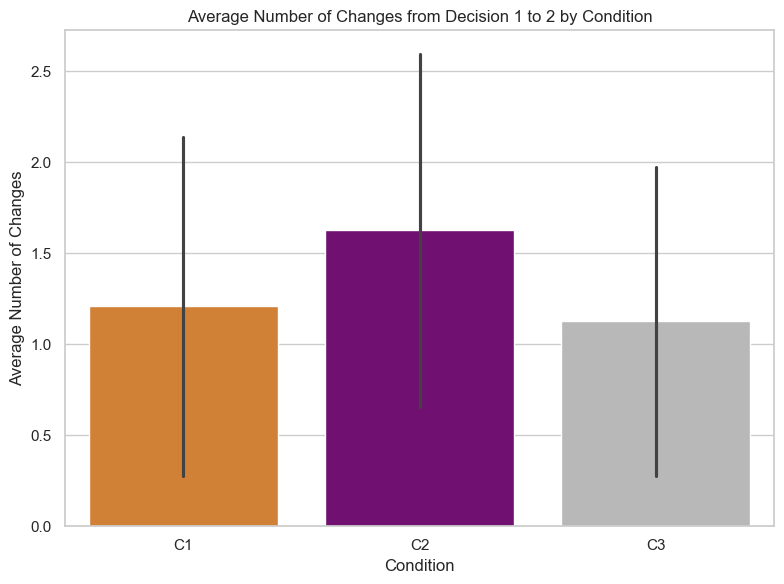

In [101]:
# SWITCH BETWEEN 1 AND 2

rows = []

participant = []
conditions = []
time = []
C1_time1_2 = []
C2_time1_2 = []
C3_time1_2 = []

C1_change1_2 = []
C2_change1_2 = []
C3_change1_2 = []


for src_file in data['source_file'].unique():
    C1_counter = 0
    C2_counter = 0
    C3_counter = 0

    for q in range(1, 13):
        for condition in range(1, 4):
            first_choice = data.loc[(data['source_file'] == src_file) & (data['question'] == f"{q}first_choiceC{condition}")]
            second_choice = data.loc[(data['source_file'] == src_file) & (data['question'] == f"{q}second_choiceC{condition}")]
            third_choice = data.loc[(data['source_file'] == src_file) & (data['question']== f"{q}third_choiceC{condition}")]

            if first_choice.shape[0] < 1 or second_choice.shape[0] < 1 or third_choice.shape[0] < 1:
                continue
        
            t1 = first_choice.iloc[0]['timestamp']
            t2 = second_choice.iloc[0]['timestamp']
            t3 = third_choice.iloc[0]['timestamp']
            if pd.notnull(t1) and pd.notnull(t2):
                participant.append(src_file)
                conditions.append(f"C{condition}")
                # time taken between phase 3 and phase 2 CHANGE HERE TO CALCULATE TIME BETWEEN phase 1 and phase 2
                if condition == 1 and (first_choice.iloc[0]['answer']!= second_choice.iloc[0]['answer']):
                    C1_counter +=1
                if condition == 2 and (first_choice.iloc[0]['answer'] != second_choice.iloc[0]['answer']):
                    C2_counter +=1
                if condition == 3 and (first_choice.iloc[0]['answer'] != second_choice.iloc[0]['answer']):
                    C3_counter +=1

    C1_change1_2.append(C1_counter)
    C2_change1_2.append(C2_counter)
    C3_change1_2.append(C3_counter)

    rows.append({
        "change": C1_counter,
        "source_file": os.path.basename(src_file),
        "condition": "C1",
    })

    rows.append({
        "change": C2_counter,
        "source_file": os.path.basename(src_file),
        "condition": "C2",
    })

    rows.append({
        "change": C3_counter,
        "source_file": os.path.basename(src_file),
        "condition": "C3",
    })

change_data = pd.DataFrame(rows)

aov = pg.friedman(data=change_data, dv='change', within='condition', subject='source_file')
print(aov)

plt.figure(figsize=(8, 6))
sns.barplot(data=change_data, x='condition', y='change', ci='sd', palette=["#ea801c", "purple", "#b8b8b8"])
plt.title('Average Number of Changes from Decision 1 to 2 by Condition')
plt.xlabel('Condition')
plt.ylabel('Average Number of Changes')
plt.tight_layout()
plt.show()

In [102]:
# import pandas as pd

# # Load the CSV (if not already loaded)
# data = pd.read_csv("data.csv")

# # Replace 'D2_D3_time' with your actual column name for time between decision 2 and 3
# time_col = 'time2_3'

# print(data['time2_3'].unique())

# # Convert the column to numeric, coercing errors (e.g., 'None', NaN) to NaN
# data['time2_3'] = pd.to_numeric(data['time2_3'], errors='coerce')

# # Check and convert time column to numeric (in case there are strings or missing)
# # data[time_col] = pd.to_numeric(data[time_col], errors='coerce')

# # Drop rows where time is NaN
# data_clean = data.dropna(subset=[time_col])

# # Group by condition and PID, then collect times into lists
# grouped = data_clean.groupby(['condition', 'PID'])[time_col].apply(list).reset_index()

# # Separate each condition into its own dictionary
# condition_1 = grouped[grouped['condition'] == 1][[time_col]].explode(time_col)[time_col].tolist()
# condition_2 = grouped[grouped['condition'] == 2][[time_col]].explode(time_col)[time_col].tolist()
# condition_3 = grouped[grouped['condition'] == 3][[time_col]].explode(time_col)[time_col].tolist()

# # Output
# print("Condition 1 times:", condition_1)
# print("Condition 2 times:", condition_2)
# print("Condition 3 times:", condition_3)


In [103]:
rows = []



for q in range(7):
    C1_q = []
    C2_q = []
    C3_q = []
    print(f"Question {q}:")
# Loop through all jsonl files
    for jsonl_path in glob.glob(os.path.join(folder_path, "*.jsonl")):
        with open(jsonl_path, "r", encoding="utf-8") as f:
            for line_num, line in enumerate(f, 1):
                line = line.strip()
                if not line:
                    continue

                try:
                    record = json.loads(line)
                except json.JSONDecodeError:
                    print(f"Skipping invalid JSON on line {line_num} in file {jsonl_path}")
                    continue

                pid = record.get("PID", None)

                for condition in range (1, 4):
                    condition_questions = record.get (f"C{condition}_questions")
                        
                    if condition == 1:
                        C1_q.append(condition_questions[q])
                    if condition == 2:
                        C2_q.append(condition_questions[q])
                    if condition == 3:
                        C3_q.append(condition_questions[q])

    print(len(C1_q))
    print(len(C2_q))
    print(len(C3_q))
    shapiro_test = stats.shapiro(C1_q)
    print(f"Condition 1")
    print(shapiro_test)

    print(f"Condition 2")
    shapiro_test = stats.shapiro(C2_q)
    print(shapiro_test)

    print(f"Condition 3")
    shapiro_test = stats.shapiro(C3_q)
    print(shapiro_test)

    print()                 

   

Question 0:
24
24
24
Condition 1
ShapiroResult(statistic=np.float64(0.8439975678437055), pvalue=np.float64(0.0016948807579648844))
Condition 2
ShapiroResult(statistic=np.float64(0.7935845392213801), pvalue=np.float64(0.000231812335487337))
Condition 3
ShapiroResult(statistic=np.float64(0.914755543879407), pvalue=np.float64(0.04477843234373009))

Question 1:
24
24
24
Condition 1
ShapiroResult(statistic=np.float64(0.8546764575344333), pvalue=np.float64(0.0026730382423859277))
Condition 2
ShapiroResult(statistic=np.float64(0.7772598831295234), pvalue=np.float64(0.0001280242850273667))
Condition 3
ShapiroResult(statistic=np.float64(0.8808081850910641), pvalue=np.float64(0.008627600416065181))

Question 2:
24
24
24
Condition 1
ShapiroResult(statistic=np.float64(0.894705960567556), pvalue=np.float64(0.016650365479480025))
Condition 2
ShapiroResult(statistic=np.float64(0.79486609264071), pvalue=np.float64(0.00024310679538008063))
Condition 3
ShapiroResult(statistic=np.float64(0.90119476178528

In [104]:
import os
import json
import glob
import pandas as pd

# Initialize list to store all rows
rows = []

# Loop over questions 0–6 (7 questions total)
for q in range(7):
    # Loop through all jsonl files
    for jsonl_path in glob.glob(os.path.join(folder_path, "*.jsonl")):
        with open(jsonl_path, "r", encoding="utf-8") as f:
            for line_num, line in enumerate(f, 1):
                line = line.strip()
                if not line:
                    continue

                try:
                    record = json.loads(line)
                except json.JSONDecodeError:
                    continue

                pid = record.get("PID", None)

                # Iterate over each condition
                for condition in range(1, 4):
                    condition_questions = record.get(f"C{condition}_questions")

                    # Defensive: make sure the question list exists and has enough entries
                    if condition_questions and q < len(condition_questions):
                        rating = condition_questions[q]
                        rows.append({
                            "PID": pid,
                            "condition": f"C{condition}",
                            "question": f"Q{q+1}",
                            "rating": rating
                        })

# Convert to DataFrame
df = pd.DataFrame(rows)

# Optional: Convert ratings to numeric if needed
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Group by condition and question, calculate mean and standard deviation
summary = df.groupby(['condition', 'question'])['rating'].agg(['mean', 'std', 'count']).reset_index()

print(summary)


   condition question      mean       std  count
0         C1       Q1  4.958333  1.829211     24
1         C1       Q2  5.625000  1.312565     24
2         C1       Q3  5.125000  1.483606     24
3         C1       Q4  6.083333  0.974308     24
4         C1       Q5  4.000000  1.817787     24
5         C1       Q6  4.791667  1.933215     24
6         C1       Q7  5.333333  1.736229     24
7         C2       Q1  4.875000  2.364824     24
8         C2       Q2  6.208333  0.931533     24
9         C2       Q3  4.916667  2.301543     24
10        C2       Q4  6.166667  1.049500     24
11        C2       Q5  3.833333  2.352920     24
12        C2       Q6  3.750000  2.131544     24
13        C2       Q7  4.333333  2.160247     24
14        C3       Q1  4.333333  1.948615     24
15        C3       Q2  5.208333  1.641292     24
16        C3       Q3  4.625000  1.929463     24
17        C3       Q4  5.666667  1.372610     24
18        C3       Q5  3.958333  1.654484     24
19        C3       Q

In [105]:
import os
import json
import glob
import pandas as pd
import scipy.stats as stats
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon

folder_path = "study-data"

rows = []

# Loop over questions 0–7 (8 questions total)
for q in range(8):
    # Loop through all jsonl files
    for jsonl_path in glob.glob(os.path.join(folder_path, "*.jsonl")):
        with open(jsonl_path, "r", encoding="utf-8") as f:
            for line_num, line in enumerate(f, 1):
                line = line.strip()
                if not line:
                    continue

                try:
                    record = json.loads(line)
                except json.JSONDecodeError:
                    continue

                pid = record.get("PID", None)

                # Iterate over each condition
                for condition in range(1, 4):
                    condition_questions = record.get(f"C{condition}_questions")

                    # Defensive: make sure the question list exists and has enough entries
                    if condition_questions and q < len(condition_questions):
                        rating = condition_questions[q]
                        rows.append({
                            "PID": pid,
                            "condition": f"C{condition}",
                            "question": f"Q{q+1}",
                            "rating": rating
                        })

# Convert to DataFrame
df = pd.DataFrame(rows)

# Convert ratings to numeric
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Remove specific attention-check questions
# df_cleaned = df[~(
#     ((df['condition'] == 'C1') & (df['question'] == 'Q4')) |
#     ((df['condition'] == 'C2') & (df['question'] == 'Q7')) |
#     ((df['condition'] == 'C3') & (df['question'] == 'Q3'))
# )]

# --- Summary statistics ---
# Calculate mean and 95% confidence interval for each group
def ci95(series):
    n = series.count()
    if n < 2:
        return np.nan
    m = series.mean()
    se = series.std(ddof=1) / np.sqrt(n)
    ci = 1.96 * se
    return ci

summary = df.groupby(['condition', 'question'])['rating'].agg(
    mean='mean',
    ci95=ci95,
    count='count'
).reset_index()

print("=== Summary Statistics (with 95% CI) ===")
print(summary)

print("\n=== Friedman Test per Question ===")

questions = df['question'].unique()

for question in sorted(questions, key=lambda x: int(x[1:])):  # Sort Q1–Q8
    subset = df[df['question'] == question]

    # Pivot so that each row corresponds to a participant (PID) and each column to a condition
    pivot = subset.pivot_table(index='PID', columns='condition', values='rating')

    # Drop rows with missing values (participant must have answered all conditions)
    pivot = pivot.dropna(subset=['C1', 'C2', 'C3'])

    if not pivot.empty:
        stat, p = friedmanchisquare(pivot['C1'], pivot['C2'], pivot['C3'])
        print(f"{question}: χ² = {stat:.3f}, p = {p:.4f}")
    else:
        print(f"{question}: Not enough complete data across conditions for Friedman test")

    # Post hoc analysis: pairwise Wilcoxon signed-rank tests between conditions

    pairs = [('C1', 'C2'), ('C1', 'C3'), ('C2', 'C3')]
    for cond1, cond2 in pairs:
        try:
            stat_w, p_w = wilcoxon(pivot[cond1], pivot[cond2])
            print(f"  {cond1} vs {cond2}: Wilcoxon W={stat_w:.3f}, p={p_w:.4f}")
        except ValueError:
            print(f"  {cond1} vs {cond2}: Not enough data for Wilcoxon test")


=== Summary Statistics (with 95% CI) ===
   condition question      mean      ci95  count
0         C1       Q1  4.958333  0.731837     24
1         C1       Q2  5.625000  0.525135     24
2         C1       Q3  5.125000  0.593566     24
3         C1       Q4  6.083333  0.389804     24
4         C1       Q5  4.000000  0.727266     24
5         C1       Q6  4.791667  0.773447     24
6         C1       Q7  5.333333  0.694636     24
7         C2       Q1  4.875000  0.946127     24
8         C2       Q2  6.208333  0.372691     24
9         C2       Q3  4.916667  0.920809     24
10        C2       Q4  6.166667  0.419887     24
11        C2       Q5  3.833333  0.941364     24
12        C2       Q6  3.750000  0.852795     24
13        C2       Q7  4.333333  0.864279     24
14        C3       Q1  4.333333  0.779608     24
15        C3       Q2  5.208333  0.656654     24
16        C3       Q3  4.625000  0.771946     24
17        C3       Q4  5.666667  0.549158     24
18        C3       Q5  3.958

/Users/26goedhuiso/Library/Python/3.9/lib/python/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/Users/26goedhuiso/Library/Python/3.9/lib/python/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/Users/26goedhuiso/Library/Python/3.9/lib/python/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/Users/26goedhuiso/Library/Python/3.9/lib/python/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/Users/26goedhuiso/Library/Python/3.9/lib/python/site-packages/s

In [106]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Your summary statistics
# data = {
#     'condition': ['C1']*8 + ['C2']*8 + ['C3']*8,
#     'question': ['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8'] * 3,
#     'mean': [
#         4.958, 5.625, 5.125, 7.000, 6.083, 4.000, 4.792, 5.333,
#         4.875, 6.208, 4.917, 6.167, 3.833, 3.750, 1.000, 4.333,
#         4.333, 5.208, 5.792, 4.625, 5.667, 3.958, 4.167, 4.167
#     ],
#     'std': [
#         1.829, 1.313, 1.484, 0.000, 0.974, 1.818, 1.933, 1.736,
#         2.365, 0.932, 2.302, 1.050, 2.353, 2.132, 0.000, 2.160,
#         1.949, 1.641, 1.021, 1.929, 1.373, 1.654, 1.857, 1.786
#     ]
# }

# df = pd.DataFrame(data)

# # Plot setup
# sns.set(style="whitegrid")
# questions = df['question'].unique()
# num_questions = len(questions)

# # Create subplots
# fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharey=True)
# axes = axes.flatten()

# # Plot each question in a separate subplot
# for i, question in enumerate(questions):
#     ax = axes[i]
#     subset = df[df['question'] == question]
#     sns.barplot(
#         x='condition', y='mean', yerr=subset['std'],
#         data=subset, ax=ax, capsize=0.2, palette='muted', errcolor='black'
#     )
#     ax.set_title(f"Question {question}")
#     ax.set_ylim(0, 8)
#     ax.set_ylabel("Mean Likert Rating")
#     ax.set_xlabel("Condition")

# # Global title and layout
# plt.suptitle("Mean Likert Scores by Question and Condition (with Std Dev)", fontsize=16)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

In [107]:

# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# Prepare the data
# data = {
#     "condition": ["C1"]*7 + ["C2"]*7 + ["C3"]*7,
#     "question": ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7"] * 3,
#     "mean": [
#         4.958333, 5.625000, 5.125000, 6.083333, 4.000000, 4.791667, 5.333333,
#         4.875000, 6.208333, 4.916667, 6.166667, 3.833333, 3.750000, 4.333333,
#         4.333333, 5.208333, 4.625000, 5.666667, 3.958333, 4.166667, 4.166667
#     ],
#     "std": [
#         1.829211, 1.312565, 1.483606, 0.974308, 1.817787, 1.933215, 1.736229,
#         2.364824, 0.931533, 2.301543, 1.049500, 2.352920, 2.131544, 2.160247,
#         1.948615, 1.641292, 1.929463, 1.372610, 1.654484, 1.857222, 1.785611
#     ]
# }

# df = pd.DataFrame(data)

# Set the style
# sns.set(style="whitegrid")
# questions = sorted(df['question'].unique())

# Create a bar plot for each question
# for q in questions:
#     plt.figure(figsize=(6, 4))
#     subset = df[df["question"] == q]

    # Barplot (Seaborn) without CI
    # ax = sns.barplot(
    #     data=subset,
    #     x="condition",
    #     y="mean",
    #     ci=None,
    #     palette = ["#ea801c", "purple", "#b8b8b8"]
    

    # Add error bars manually using matplotlib
    # x_coords = range(len(subset))
    # ax.errorbar(
    #     x=x_coords,
    #     y=subset["mean"],
    #     yerr=subset["std"],
    #     fmt='none',
    #     c='black',
    #     capsize=5
    # )

    # plt.title(f"Mean Response for {q}")
    # plt.ylim(0, 10)  # Likert scale
    # plt.ylabel("Mean")
    # plt.xlabel("Condition")
    # plt.tight_layout()
    # plt.show()


    




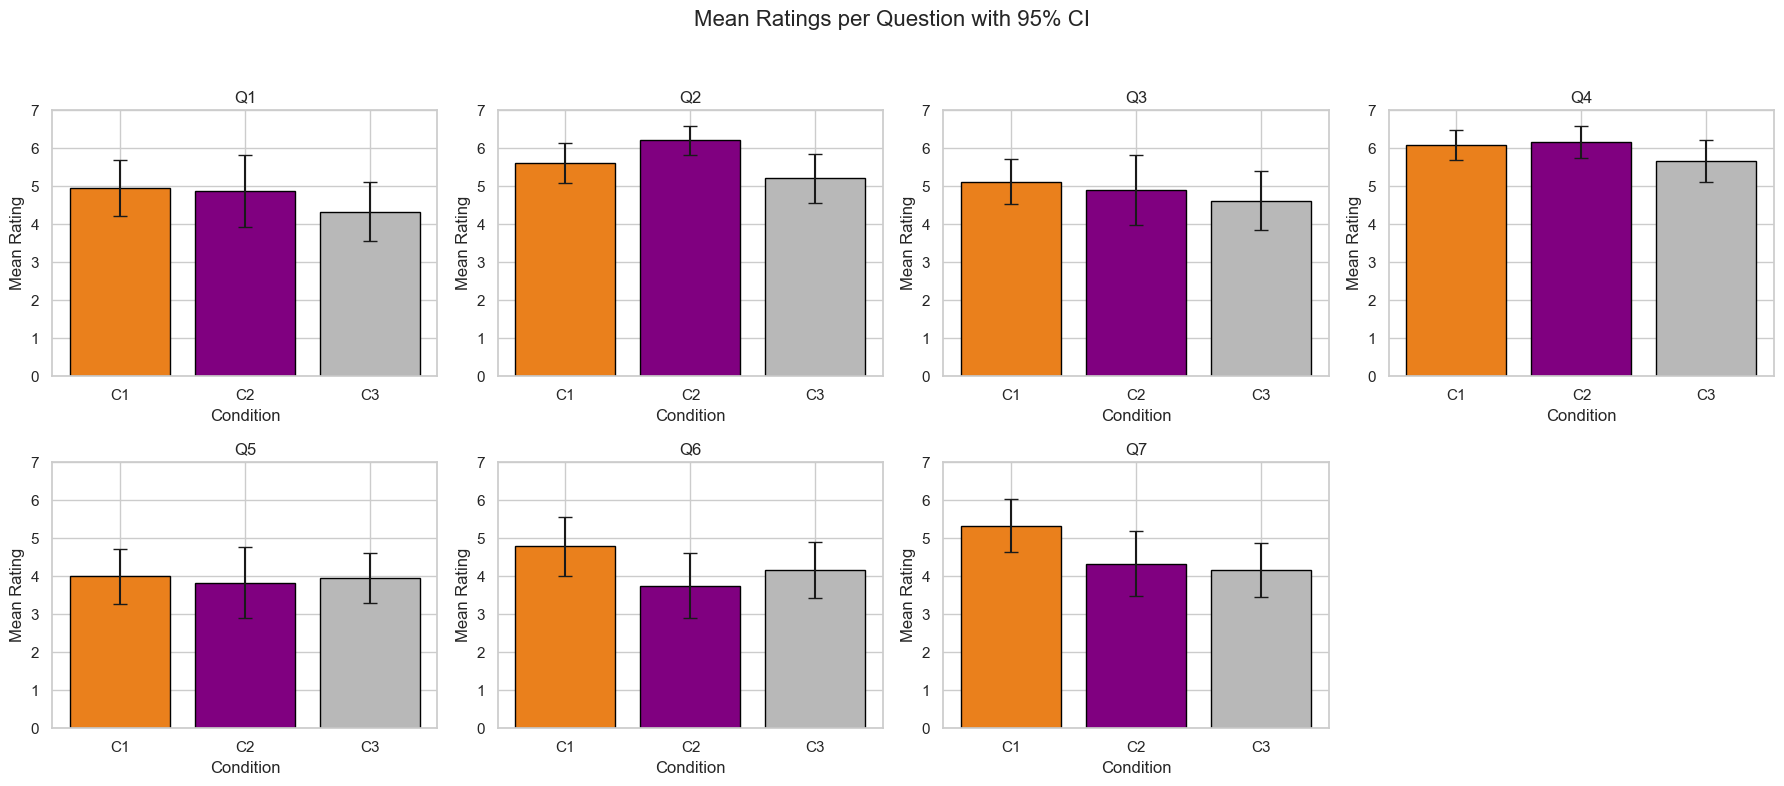

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Your Summary Data ===
data = {
    "condition": ['C1'] * 7 + ['C2'] * 7 + ['C3'] * 7,
    "question": ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7'] * 3,
    "mean": [
        4.958333, 5.625000, 5.125000, 6.083333, 4.000000, 4.791667, 5.333333,
        4.875000, 6.208333, 4.916667, 6.166667, 3.833333, 3.750000, 4.333333,
        4.333333, 5.208333, 4.625000, 5.666667, 3.958333, 4.166667, 4.166667
    ],
    "ci95": [
        0.731837, 0.525135, 0.593566, 0.389804, 0.727266, 0.773447, 0.694636,
        0.946127, 0.372691, 0.920809, 0.419887, 0.941364, 0.852795, 0.864279,
        0.779608, 0.656654, 0.771946, 0.549158, 0.661932, 0.743044, 0.714393
    ],
    "count": [24] * 21
}

df = pd.DataFrame(data)

# === Plot ===
sns.set(style="whitegrid")
questions = sorted(df["question"].unique(), key=lambda x: int(x[1:]))

# Set up color palette
palette = {"C1": "#4C72B0", "C2": "#55A868", "C3": "#C44E52"}

# Create one figure with subplots for each question
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
axes = axes.flatten()

for i, question in enumerate(questions):
    ax = axes[i]
    subset = df[df['question'] == question]
    
    ax.bar(
        subset["condition"],
        subset["mean"],
        yerr=subset["ci95"],
        capsize=5,
        color=["#ea801c", "purple", "#b8b8b8"],
        edgecolor='black'
    )
    
    ax.set_title(f"{question}")
    ax.set_ylim(0, 7)
    ax.set_ylabel("Mean Rating")
    ax.set_xlabel("Condition")

# Remove any empty subplot
for j in range(len(questions), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Mean Ratings per Question with 95% CI", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [109]:
import os
import glob
import json

rows = []

# Loop through all jsonl files
for jsonl_path in glob.glob(os.path.join(folder_path, "*.jsonl")):
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue

            try:
                record = json.loads(line)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON on line {line_num} in file {jsonl_path}")
                continue

            pid = record.get("PID")
            post_questions = record.get("post_questions", [])

            if not isinstance(post_questions, list):
                print(f"Unexpected format for post_questions in file {jsonl_path}")
                continue

            for i, answer in enumerate(post_questions):
                rows.append({
                    "PID": pid,
                    "question": f"Q{i+1}",
                    "answer": answer,
                    "source_file": os.path.basename(jsonl_path)
                })


# data = [
#     {
#         "PID": 1,
#         "post_questions": [
#             "not inclined", "somewhat inclined", "inclined", "very inclined",
#             "interactive features", "explanations", "explanations", "explanations", "explanations",
#             "images", "images"
#         ]
#     },
#     {
#         "PID": 2,
#         "post_questions": [
#             "not inclined", "not inclined", "not inclined", "somewhat inclined",
#             "interactive features", "explanations", "explanations", "explanations", "explanations",
#             "images", "images"
#         ]
#     },
    # Add more participants...


# === Step 2: Transform to DataFrame ===
data = pd.DataFrame(rows)

# Optional: Convert timestamp column to datetime
# data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')


print(data.head())

# === NEW: Pivot answers so each PID has answers for each question ===
data_full = data.pivot(index="PID", columns="question", values="answer")
print(data_full.head())

# === Step 3: Aggregate response counts per question ===
question_cols = data_full.columns

agg_counts = {}
for col in question_cols:
    agg_counts[col] = data_full[col].value_counts()

agg_df = pd.DataFrame(agg_counts).fillna(0).astype(int).T

# Expand post_questions into separate columns
# data_expanded = data["post_questions"].apply(pd.Series)
# data_expanded.columns = [f"Q{i+1}" for i in range(data_expanded.shape[1])]
# data_full = pd.concat([df["PID"], data_expanded], axis=1)

# === Step 3: Aggregate response counts per question ===
# question_cols = data_expanded.columns

# agg_counts = {}
# for col in question_cols:
#     agg_counts[col] = data_full[col].value_counts()

# agg_df = pd.DataFrame(agg_counts).fillna(0).astype(int).T

# === Step 4: Plot distribution of responses per question ===
plt.figure(figsize=(12, 6))
agg_df.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="Set3")
plt.title("Distribution of Multiple-Choice Responses per Question")
plt.ylabel("Number of Participants")
plt.xlabel("Question")
plt.xticks(rotation=45)
plt.legend(title="Response", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
                   





Empty DataFrame
Columns: []
Index: []


KeyError: 'PID'

this is question 1
answer
somewhat inclined    10
not inclined          8
quite inclined        5
very inclined         1
Name: count, dtype: int64
this is question 2
answer
quite inclined       9
somewhat inclined    7
not inclined         5
very inclined        3
Name: count, dtype: int64
this is question 3
answer
quite inclined       8
not inclined         7
somewhat inclined    6
very inclined        3
Name: count, dtype: int64
this is question 4
answer
somewhat inclined    9
quite inclined       7
not inclined         6
very inclined        2
Name: count, dtype: int64
this is question 5
answer
explanations            13
interactive features     7
images                   4
Name: count, dtype: int64
this is question 6
answer
explanations            13
interactive features     7
images                   4
Name: count, dtype: int64
this is question 7
answer
explanations            12
interactive features     8
images                   4
Name: count, dtype: int64
this is question 8
an

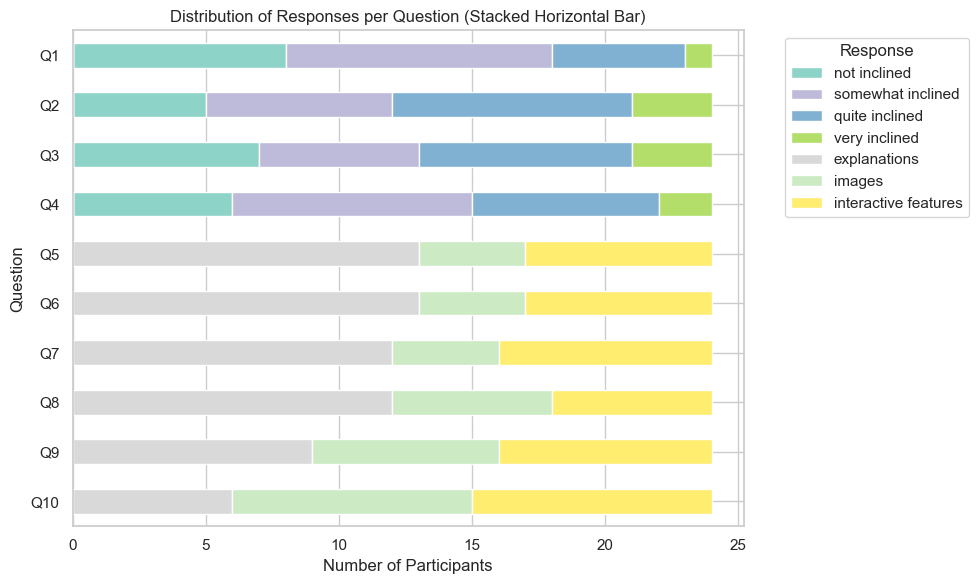

In [ ]:
import os
import glob
import json

rows = []

# Loop through all jsonl files
for jsonl_path in glob.glob(os.path.join(folder_path, "*.jsonl")):
    
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue

            try:
                record = json.loads(line)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON on line {line_num} in file {jsonl_path}")
                continue

            pid = record.get("PID")
            post_questions = record.get("post_quesitons", [])
           

            if not isinstance(post_questions, list):
                print(f"Unexpected format for post_quesitons in file {jsonl_path}")
                continue

            for i, answer in enumerate(post_questions):
                rows.append({
                    "PID": pid,
                    "question": f"Q{i+1}",
                    "answer": answer,
                    "source_file": os.path.basename(jsonl_path)
                })



# === Step 2: Transform to DataFrame ===
data = pd.DataFrame(rows)

# Define the desired order for the answer labels
answer_order = ["not inclined", "somewhat inclined", "quite inclined", "very inclined", "explanations", "images", "interactive features"]

for q in range(1, 12):
    print(f"this is question {q}")
    summary = data[data['question']==f'Q{q}']['answer'].value_counts()
    print(summary)

# Pivot with all possible answers as columns, in the desired order
pivot_df = data.pivot_table(
    index='question',
    columns='answer',
    values='PID',
    aggfunc='count',
    fill_value=0
)

# Ensure columns are in the specified answer order (add missing columns if needed)
for ans in answer_order:
    if ans not in pivot_df.columns:
        pivot_df[ans] = 0
pivot_df = pivot_df[answer_order]

# Sort questions so Q1 is at the top and Q11 at the bottom
question_order = [f"Q{i}" for i in range(10, 0, -1)]
pivot_df = pivot_df.reindex(question_order)

# Plot stacked horizontal bar chart with the specified answer order
ax = pivot_df.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='Set3')
ax.set_xlabel('Number of Participants')
ax.set_ylabel('Question')
ax.set_title('Distribution of Responses per Question (Stacked Horizontal Bar)')
plt.legend(title='Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
